In [53]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [55]:
# Build the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

vocab_size = len(stoi)

print ( itos )

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [56]:
# Build the dataset
block_size = 3

def build_dataset(words):
    X,Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
# Init the parameters

n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed), generator=g)
W1 = torch.rand((n_embed*block_size,n_hidden), generator=g) * (5/3) / ((n_embed*block_size)**0.5)
b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size), generator=g) * (5/3) / ((n_hidden)**0.5)
b2 = torch.randn(vocab_size, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters)

11897

In [9]:
# Forward pass
losses = []
steps = []
batch_size = 32
max_steps = 200000
for i in range(max_steps):
    
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy( logits, Ytr[ix] )

    # Backwards pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    ## Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    losses.append(loss.log10().item())
    steps.append(i)
    
    if i % 10000 == 0:
        print ( f'{i:7d}/{max_steps:7d}: {loss.item():0.4f}' )

      0/ 200000: 3.6052
  10000/ 200000: 2.2049
  20000/ 200000: 2.1480
  30000/ 200000: 2.0884
  40000/ 200000: 1.8438
  50000/ 200000: 2.0189
  60000/ 200000: 2.2380
  70000/ 200000: 2.1591
  80000/ 200000: 2.2937
  90000/ 200000: 2.1456
 100000/ 200000: 2.1698
 110000/ 200000: 2.2946
 120000/ 200000: 1.8875
 130000/ 200000: 2.1950
 140000/ 200000: 1.6716
 150000/ 200000: 1.9556
 160000/ 200000: 2.2321
 170000/ 200000: 1.7473
 180000/ 200000: 1.9828
 190000/ 200000: 1.6382


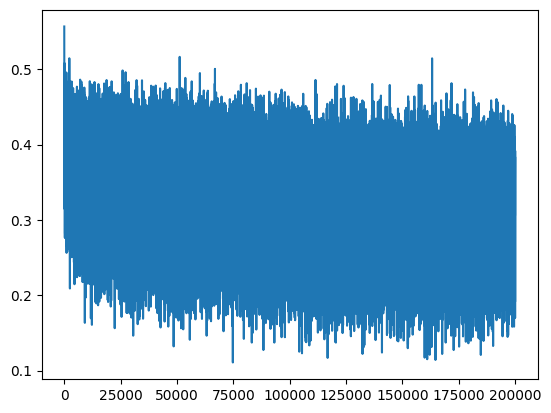

In [10]:
plt.plot( steps, losses )

In [11]:
# Print loss over all datasets
@torch.no_grad()
def split_loss( split ):
    X,Y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte)
    }[split]
    
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy( logits, Y )
    print ( loss.item() )
    
split_loss( 'train' )
split_loss( 'val' )
split_loss( 'test' )

2.044201135635376
2.105173349380493
2.104893684387207


In [12]:
g = torch.Generator().manual_seed(2147483647)
                                  
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1,30) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ( ix == 0 ):
            break
    print( ''.join(itos[i] for i in out))
                  

junide.
jakariz.
presay.
adin.
kai.
ritolious.
ter.
kalinaa.
zamilena.
jadeddine.
imilysson.
evy.
artezundelyn.
afontum.
maryas.
jah.
jaylie.
reaysen.
cary.
jamir.


In [22]:
# Init the parameters

n_embed = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embed), generator=g)
W1 = torch.rand((n_embed*block_size,n_hidden), generator=g) * (5/3) / ((n_embed*block_size)**0.5)
W2 = torch.randn((n_hidden,vocab_size), generator=g) * (5/3) / ((n_hidden)**0.5)
b2 = torch.randn(vocab_size, generator=g) * 0

bn_gain = torch.ones((1,n_hidden))
bn_bias = torch.zeros((1,n_hidden))

parameters = [C, W1, W2, b2, bn_gain, bn_bias]

bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

for p in parameters:
    p.requires_grad = True
    
sum(p.nelement() for p in parameters)

12097

In [23]:
# Forward pass
losses = []
steps = []
batch_size = 32
max_steps = 200000

for i in range(max_steps):
    
    ix = torch.randint(0,Xtr.shape[0],(batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)    
    hpreact = bn_gain*(hpreact - bnmeani )/bnstdi + bn_bias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy( logits, Ytr[ix] )

    # Backwards pass
    for p in parameters:
        p.grad = None 
    loss.backward()

    ## Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    losses.append(loss.log10().item())
    steps.append(i)
    
    if i % 10000 == 0:
        print ( f'{i:7d}/{max_steps:7d}: {loss.item():0.4f}' )

      0/ 200000: 3.7950
  10000/ 200000: 2.1019
  20000/ 200000: 2.3026
  30000/ 200000: 2.0641
  40000/ 200000: 2.4394
  50000/ 200000: 1.7125
  60000/ 200000: 2.0490
  70000/ 200000: 2.4119
  80000/ 200000: 2.2106
  90000/ 200000: 2.5596
 100000/ 200000: 2.3645
 110000/ 200000: 2.1426
 120000/ 200000: 2.0107
 130000/ 200000: 2.7122
 140000/ 200000: 2.1466
 150000/ 200000: 2.1290
 160000/ 200000: 1.9267
 170000/ 200000: 2.2075
 180000/ 200000: 2.0798
 190000/ 200000: 2.3055


In [24]:
# Print loss over all datasets
@torch.no_grad()
def split_loss( split ):
    X,Y = {
        'train': (Xtr,Ytr),
        'val': (Xdev,Ydev),
        'test': (Xte,Yte)
    }[split]
    
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bn_gain*(hpreact - bnmean_running)/bnstd_running + bn_bias #Use fixed mean and std
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy( logits, Y )
    print ( loss.item() )
    
split_loss( 'train' )
split_loss( 'val' )
split_loss( 'test' )

2.0674595832824707
2.1105716228485107
2.10591983795166


In [110]:
class Linear:
    def __init__(self,fan_in,fan_out, bias=True):
        self.weight = torch.randn((fan_in,fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNormId:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        self.out.requires_grad = True
    
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
      
        
n_embed = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)
layers = [
    Linear(n_embed*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]
with torch.no_grad():
    layers[-1].weight *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

46497


In [111]:
max_steps = 200*1000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # Backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < max_steps/2 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # Stats
    if i%(max_steps/100)==0:
        print( f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break
    

      0/ 200000: 3.3019


layer 0 (    Linear): mean -0.02, std 0.99, saturated 32.16%
layer 1 (    Linear): mean -0.01, std 0.98, saturated 31.12%
layer 2 (    Linear): mean -0.00, std 1.01, saturated 31.16%
layer 3 (    Linear): mean +0.01, std 0.97, saturated 31.66%
layer 4 (    Linear): mean -0.06, std 0.99, saturated 32.47%


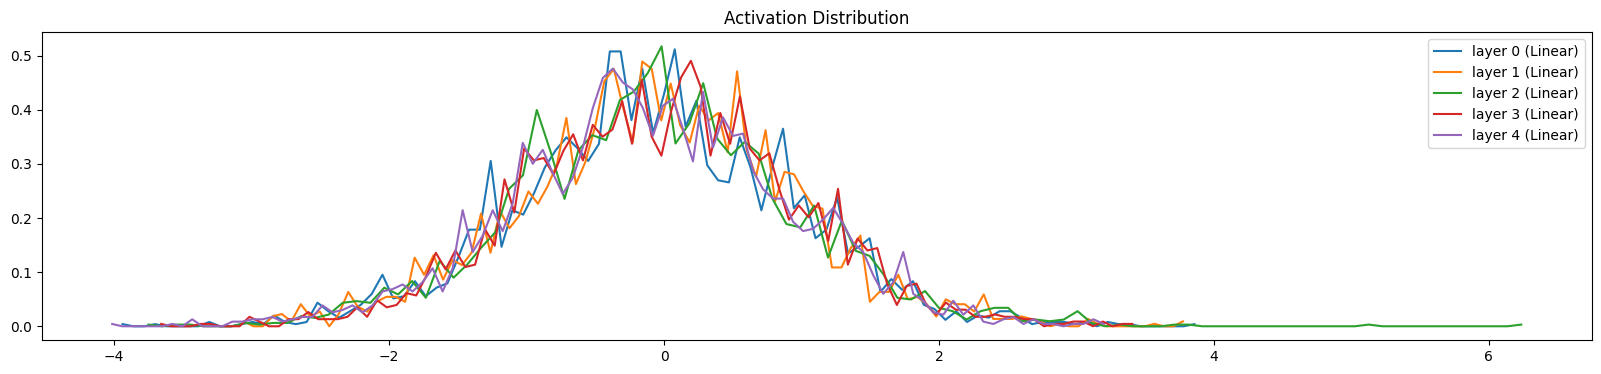

In [112]:
plt.figure(figsize=(20,4))
legends=[]
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Linear):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title( 'Activation Distribution');

0 (    Linear): mean +0.0000054, std 3.190493e-04
1 (    Linear): mean -0.0000039, std 3.204010e-04
2 (    Linear): mean +0.0000149, std 3.229072e-04
3 (    Linear): mean +0.0000184, std 3.127774e-04
4 (    Linear): mean -0.0000136, std 3.055150e-04


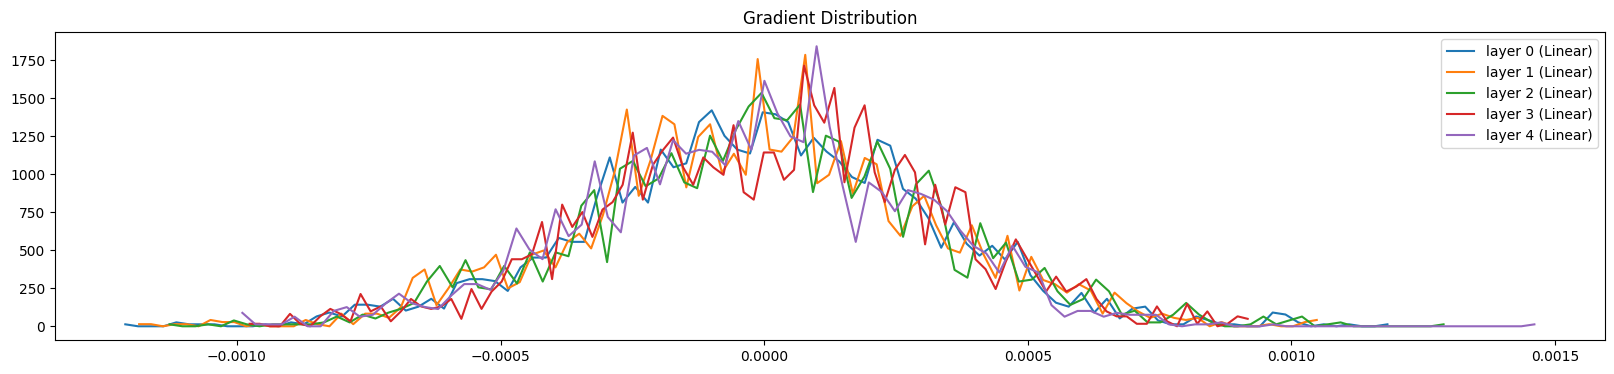

In [113]:
plt.figure(figsize=(20,4))
legends=[]
for i,layer in enumerate(layers[:-1]):
    if isinstance(layer,Linear):
        t = layer.out.grad
        print ( f'%d (%10s): mean %+.7f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient Distribution');